Image Approximation with Fourier and Wavelets
=============================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This numerical tour overviews the use of Fourier and wavelets for image
approximation.

In [1]:
from __future__ import division

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *
#from nt_solutions import introduction_4_fourier_wavelets as solutions

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

*Note:* to measure the error of an image $f$ with its
approximation $f_M$, we use the SNR measure, defined as

$$ \text{SNR}(f,f_M) = -20\log_{10} \pa{ \frac{ \norm{f-f_M} }{ \norm{f} } },  $$

which is a quantity expressed in decibels (dB).
The higer the SNR, the better the quality.

Image Loading and Displaying
----------------------------


First we load an image $ f \in \RR^N $ of $ N = N_0 \times N_0 $ pixels.

In [2]:
n0 = 512
f = rescale(load_image("toolbox_signal/lena.bmp", n0))

Display the original image.

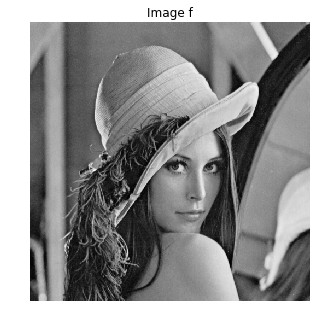

In [3]:
plt.figure(figsize = (5,5))
imageplot(f, 'Image f')

Display a zoom in the middle.

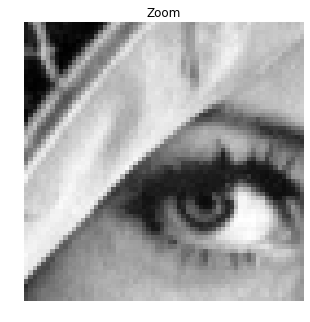

In [4]:
plt.figure(figsize = (5,5))
imageplot(f[n0//2 - 32:n0//2 + 32,n0//2 - 32:n0//2 + 32], 'Zoom')

An image is a 2D array, it can be modified as a matrix.

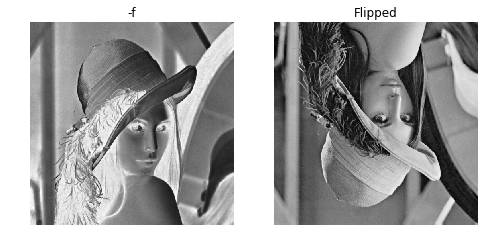

In [5]:
plt.figure(figsize = (8,8))
imageplot(-f, '-f', [1, 2, 1])
imageplot(f[::-1,], 'Flipped', [1, 2, 2])

Blurring is achieved by computing a convolution $f \star h$ with a kernel $h$.


Compute the low pass kernel.

In [6]:
k = 9; #size of the kernel
h = np.ones([k,k])
h = h/np.sum(h) #normalize

Compute the convolution $f \star h$.

In [7]:
from scipy import signal
fh = signal.convolve2d(f, h, boundary = "symm")

Display.

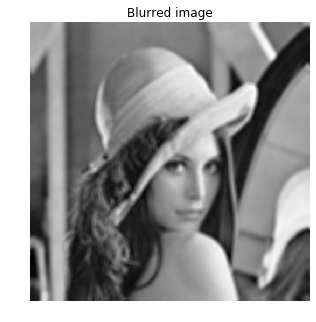

In [8]:
plt.figure(figsize = (5,5))
imageplot(fh, 'Blurred image')

Fourier Transform
-----------------
The Fourier orthonormal basis is defined as
$$ \psi_m(k) = \frac{1}{\sqrt{N}}e^{\frac{2i\pi}{N_0} \dotp{m}{k} } $$
where $0 \leq k_1,k_2 < N_0$ are position indexes,
and $0 \leq m_1,m_2 < N_0$ are frequency indexes.


The Fourier transform $\hat f$ is the projection of the image on this Fourier
basis

$$ \hat f(m) = \dotp{f}{\psi_m}. $$


The Fourier transform is computed in $ O(N \log(N)) $ operation using the FFT algorithm
(Fast Fourier Transform).
Note the normalization by $\sqrt{N}=N_0$ to make the transform orthonormal.

In [9]:
F = pyl.fft2(f)/n0

We check this conservation of the energy.

In [10]:
from pylab import linalg

print("Energy of Image:   %f" %linalg.norm(f))
print("Energy of Fourier: %f" %linalg.norm(F))

Energy of Image:   255.983054
Energy of Fourier: 255.983054


Compute the logarithm of the Fourier magnitude $ \log\left(\abs{\hat f(m)} +
\epsilon\right) $, for some small $\epsilon$.

In [11]:
L = pyl.fftshift(np.log(abs(F) + 1e-1))

Display. Note that we use the function fftshift to put the 0 low frequency in the
middle.

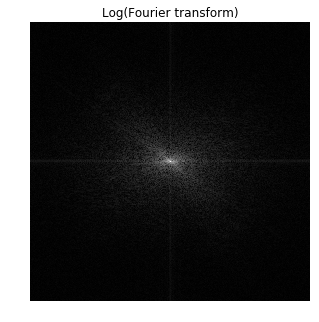

In [12]:
plt.figure(figsize = (5,5))
imageplot(L, 'Log(Fourier transform)')

Linear Fourier Approximation
----------------------------
An approximation is obtained by retaining a certain set of index $I_M$

$$ f_M = \sum_{ m \in I_M } \dotp{f}{\psi_m} \psi_m. $$


Linear approximation is obtained by retaining a *fixed* set $I_M$
of $M = \abs{I_M}$ coefficients. The important point is that $I_M$
does not depend on the image $f$ to be approximated.


For the Fourier transform, a low pass linear approximation
is obtained by keeping only the frequencies within a square.

$$ I_M = \enscond{m=(m_1,m_2)}{ -q/2 \leq m_1,m_2 < q/2 } $$
where $ q = \sqrt{M} $.


This can be achieved by computing the Fourier transform,
setting to zero the $N-M$ coefficients outside the square $I_M$
and then inverting the Fourier transform.


Number $M$ of kept coefficients.

In [13]:
M = n0**2//64

__Exercise 1__

Perform the linear Fourier approximation with $M$ coefficients.
Store the result in the variable $f_M$.

In [14]:
#solutions.exo1()

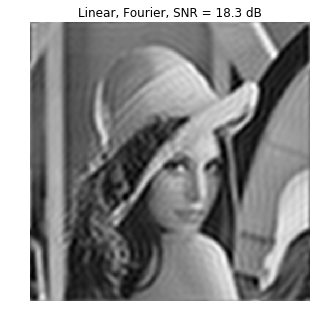

In [15]:
## Insert your code here.
q = int(np.sqrt(M))
F = pyl.fftshift(pyl.fft2(f))
Sel = np.zeros([n0,n0])

Sel[n0//2 - q//2:n0//2 + q//2, n0//2 - q//2:n0//2 + q//2] = 1
F_zeros = np.multiply(F,Sel)

fM = np.real(pyl.ifft2(pyl.fftshift(F_zeros)))
plt.figure(figsize = (5,5))
imageplot(clamp(fM), "Linear, Fourier, SNR = %.1f dB" %snr(f, fM))

Compare two 1D profile (lines of the image).
This shows the strong ringing artifact of the linea approximation.

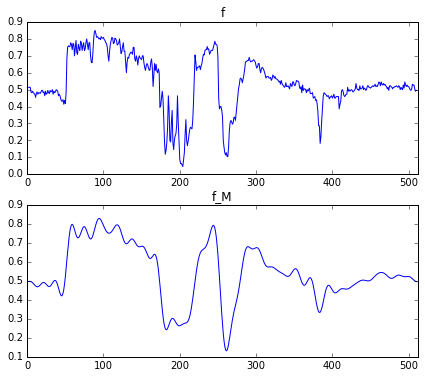

In [16]:
plt.figure(figsize=(7,6))

plt.subplot(2, 1, 1)
plt.plot(f[: , n0//2])
plt.xlim(0,n0)
plt.title('f')

plt.subplot(2, 1, 2)
plt.plot(fM[: , n0//2])
plt.xlim(0,n0)
plt.title('f_M')

plt.show()

Non-linear Fourier Approximation
--------------------------------
Non-linear approximation is obtained by keeping the $M$ largest
coefficients. This is equivalently computed using a thresholding of the
coefficients
$$ I_M = \enscond{m}{ \abs{\dotp{f}{\psi_m}}>T }. $$


Set a threshold $T>0$.

In [17]:
T = .2

Compute the Fourier transform.

In [18]:
F = pyl.fft2(f)/n0

Do the hard thresholding.

In [19]:
FT = np.multiply(F,(abs(F) > T))

Display. Note that we use the function fftshift to put the 0 low frequency in the
middle.

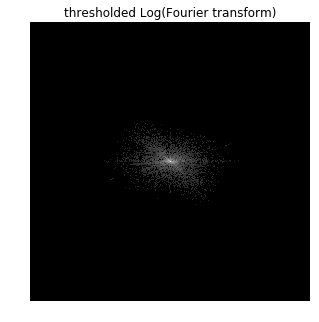

In [20]:
L = pyl.fftshift(np.log(abs(FT) + 1e-1))
plt.figure(figsize = (5,5))
imageplot(L, 'thresholded Log(Fourier transform)')

Inverse Fourier transform to obtain $f_M$.

In [21]:
fM = np.real(pyl.ifft2(FT)*n0)

Display.

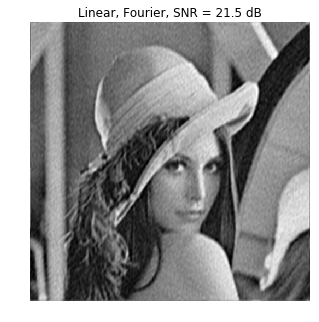

In [22]:
plt.figure(figsize = (5,5))
imageplot(clamp(fM), "Linear, Fourier, SNR = %.1f dB" %snr(f, fM))

Given a $T$, the number of coefficients is obtained by counting the
non-thresholded coefficients $ \abs{I_M} $.

In [23]:
m = np.sum(FT != 0)
print('M/N = 1/%d'  %(n0**2/m))

M/N = 1/31


__Exercise 2__

Compute the value of the threshold $T$ so that the number of
coefficients is $M$. Display the corresponding approximation
$f_M$.

In [24]:
#solutions.exo2()

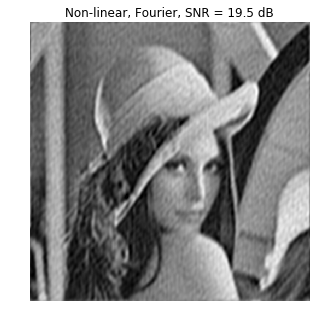

In [25]:
## Insert your code here.
F = pyl.fft2(f)
a = np.sort(np.ravel(abs(F)))[::-1] #sort a 1D copy of F in descending order
T = a[M]
FT = np.multiply(F,(abs(F) > T))
fM = np.real(pyl.ifft2(FT))
plt.figure(figsize = (5,5))
imageplot(clamp(fM), "Non-linear, Fourier, SNR = %.1f dB" %snr(f, fM))

Wavelet Transform
-----------------
A wavelet basis $ \Bb = \{ \psi_m \}_m $
is obtained over the continuous domain by translating and
dilating three mother wavelet functions $ \{\psi^V,\psi^H,\psi^D\} $.


Each wavelet atom is defined as
$$ \psi_m(x) = \psi_{j,n}^k(x) = \frac{1}{2^j}\psi^k\pa{ \frac{x-2^j n}{2^j} } $$

The scale (size of the support) is $2^j$ and the position is
$2^j(n_1,n_2)$. The index is $ m=(k,j,n) $ for $\{ j \leq 0 \}$.


The wavelet transform computes all the inner products
$ \{ \dotp{f}{\psi_{j,n}^k} \}_{k,j,n} $.


Set the minimum scale for the transform to be 0.

In [26]:
Jmin = 0

Perform the wavelet transform,  $f_w$ stores all the wavelet coefficients.

In [27]:
from nt_toolbox.perform_wavelet_transf import *

fw = perform_wavelet_transf(f, Jmin, + 1)

Display the transformed coefficients.

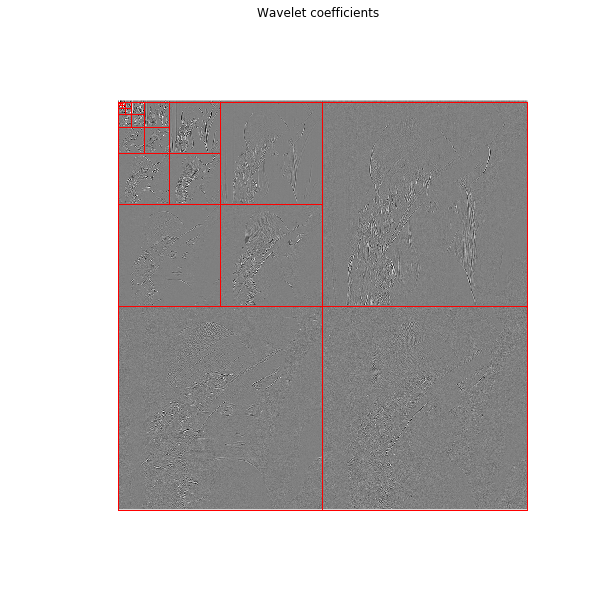

In [28]:
plt.figure(figsize=(10,10))

plot_wavelet(fw)
plt.title('Wavelet coefficients')

plt.show()

Wavelet Approximation
---------------------
Linear wavelet approximation with $M=2^{-j_0}$ coefficients is obtained
by keeping only the coarse scale (large support) wavelets:

$$ I_M = \enscond{(k,j,n)}{ j \geq j_0 }. $$


It corresponds to setting to zero all the coefficients excepted those
that are on the upper left corner of $f_w$.

__Exercise 3__

Perform linear approximation with $M$ wavelet coefficients.

In [29]:
#solutions.exo3()

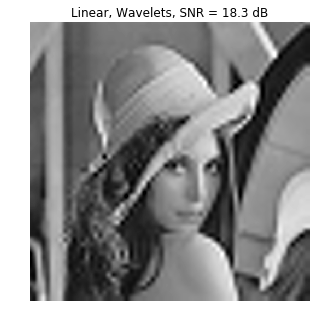

In [30]:
## Insert your code here.
q = int(np.sqrt(M))
fw = perform_wavelet_transf(f, Jmin, +1)
fw1 = np.zeros([n0, n0])
fw1[:q, :q] = fw[:q, :q]
fM = perform_wavelet_transf(fw1, Jmin, -1)
plt.figure(figsize=(5,5))
imageplot(clamp(fM),  "Linear, Wavelets, SNR = %.1f dB" %snr(f, fM))

A non-linear approximation is obtained by keeping the $M$ largest wavelet
coefficients.


As already said, this is equivalently computed by a non-linear hard
thresholding.


Select a threshold.

In [31]:
T = .15

Perform hard thresholding.

In [32]:
fwT = np.multiply(fw,(abs(fw) > T))

Display the thresholded coefficients.

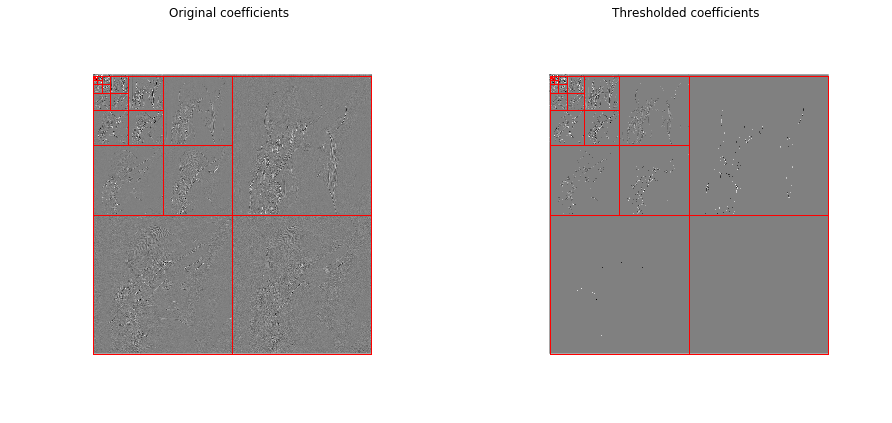

In [33]:
plt.figure(figsize=(15,15))

plt.subplot(1, 2, 1)
plot_wavelet(fw)
plt.title('Original coefficients')

plt.subplot(1, 2, 2)
plot_wavelet(fwT)
plt.title('Thresholded coefficients')

plt.show()

Perform reconstruction.

In [34]:
fM = perform_wavelet_transf(fwT, Jmin, -1)

Display approximation.

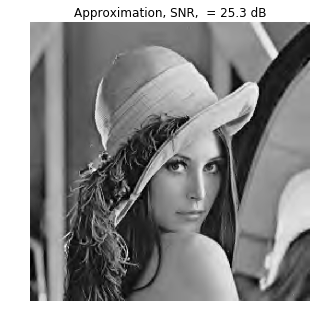

In [35]:
plt.figure(figsize=(5,5))
imageplot(clamp(fM), "Approximation, SNR,  = %.1f dB" %snr(f, fM))

__Exercise 4__

Perform non-linear approximation with $M$ wavelet coefficients by
chosing the correct value for $T$. Store the result in the variable
$f_M$.

In [36]:
#solutions.exo4()

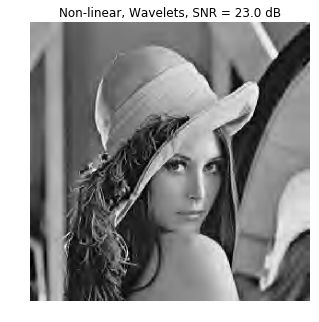

In [37]:
## Insert your code here.

fw = perform_wavelet_transf(f, Jmin, +1)
a = np.sort(np.ravel(abs(fw)))[::-1] #sort a 1D copy of fw in descending order
T = a[M]
fw1 = np.multiply(fw,(abs(fw) > T))
fM = perform_wavelet_transf(fw1, Jmin, -1)
plt.figure(figsize=(5,5))
imageplot(clamp(fM), "Non-linear, Wavelets, SNR = %.1f dB" %snr(f, fM))

Compare two 1D profile (lines of the image).
Note how the ringing artifacts are reduced compared to the Fourier
approximation.

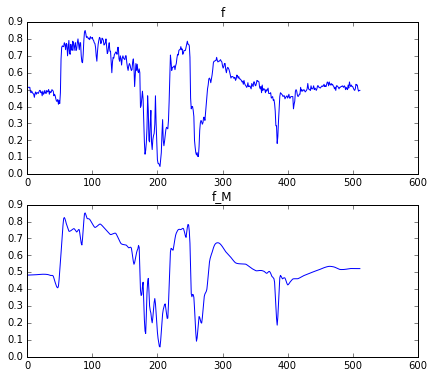

In [38]:
plt.figure(figsize=(7,6))

plt.subplot(2, 1, 1)
plt.plot(f[:,n0//2])
plt.title('f')

plt.subplot(2, 1, 2)
plt.plot(fM[:,n0//2])
plt.title('f_M')

plt.show()